In [5]:
# delete this cell if working on Pycharm
!pip install Bio
!pip install import-ipynb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 270 kB 12.9 MB/s 
     |████████████████████████████████| 2.3 MB 54.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
from Bio.PDB import *
import numpy as np
import os
from tqdm import tqdm

In [7]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

# so we can import utils notebook (delete if working on Pycharm), you might need to change it to your working directory path
%cd "/content/drive/MyDrive/Colab Notebooks/" 

import import_ipynb
import utils

/content/drive/MyDrive/Colab Notebooks
importing Jupyter notebook from utils.ipynb
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
MAX_LEN = utils.SH2_MAX_LEN + utils.PEP_MAX_LEN
FEATURE_NUM = utils.FEATURE_NUM

# output column size
DENSE_UNITS = 15
MODEL_PATH = "SH2_and_pep_model"

###############################################################################
#                                                                             
#              Parameters you can change, but don't have to                   #
#                                                                             #
###############################################################################


# number of ResNet blocks for the first ResNet and the kernel size.
RESNET_1_BLOCKS = 3
RESNET_1_KERNEL_SIZE = 15
RESNET_1_KERNEL_NUM = 32


###############################################################################
#                                                                             #
#                        Parameters you need to choose                        #
#                                                                             #
###############################################################################


# number of ResNet blocks for the second ResNet, dilation list to repeat and the kernel size.

RESNET_2_BLOCKS = 1
RESNET_2_KERNEL_SIZE = 5  # good start may be 3/5
RESNET_2_KERNEL_NUM = 64
DILATION = [1,2,4, 8, 16]

# percentage of dropout for the dropout layer
DROPOUT = 0.1 # good start may be 0.1-0.5

# number of epochs, Learning rate and Batch size
EPOCHS = 150
LR = 0.003 # good start may be 0.0001/0.001/0.01
BATCH = 30 # good start may be 32/64/128

TEST_PERCENT = 10


In [11]:
def resnet_1(input_layer):  # TODO: implement this!
    """
    ResNet layer - input -> BatchNormalization -> Conv1D -> Relu -> BatchNormalization -> Conv1D -> Relu -> Add
    :param input_layer: input layer for the ResNet
    :return: last layer of the ResNet
    """
    for k in range(RESNET_1_BLOCKS):
      batch_layer = tf.keras.layers.BatchNormalization()(input_layer)
      conv1d_layer = layers.Conv1D(RESNET_1_KERNEL_NUM, RESNET_1_KERNEL_SIZE, padding='same')(batch_layer)
      relu_layer = tf.keras.layers.ReLU()(conv1d_layer)
      batch_layer = tf.keras.layers.BatchNormalization()(relu_layer)
      conv1d_layer = layers.Conv1D(RESNET_1_KERNEL_NUM, RESNET_1_KERNEL_SIZE, padding='same')(batch_layer)
      relu_layer = tf.keras.layers.ReLU()(conv1d_layer)
      input_layer = layers.Add()([input_layer, relu_layer])
    return input_layer



In [12]:
def resnet_2(input_layer):  # TODO: implement this!
    """
    Dilated ResNet layer - input -> BatchNormalization -> dilated Conv1D -> Relu -> BatchNormalization -> dilated Conv1D -> Relu -> Add
    :param input_layer: input layer for the ResNet
    :return: last layer of the ResNet
    """
    for n in range(RESNET_2_BLOCKS):
       for m in DILATION:
          batch_layer = tf.keras.layers.BatchNormalization()(input_layer)
          conv1d_layer = layers.Conv1D(RESNET_2_KERNEL_NUM, RESNET_2_KERNEL_SIZE, dilation_rate=m, padding='same')(batch_layer)
          relu_layer = tf.keras.layers.ReLU()(conv1d_layer)
          batch_layer = tf.keras.layers.BatchNormalization()(relu_layer)
          conv1d_layer = layers.Conv1D(RESNET_2_KERNEL_NUM, RESNET_2_KERNEL_SIZE, dilation_rate=m, padding='same')(batch_layer)
          relu_layer = tf.keras.layers.ReLU()(conv1d_layer)
          input_layer = layers.Add()([input_layer, relu_layer])
    return input_layer

In [13]:
def build_network():
    """
    builds the neural network architecture as shown in the exercise.
    :return: a Keras Model
    """
    # input, shape (MAX_LENGTH,FEATURE_NUM)
    input_layer = tf.keras.Input(shape=(MAX_LEN, FEATURE_NUM))

    # Conv1D -> shape = (MAX_LENGTH, RESNET_1_KERNEL_NUM)
    conv1d_layer = layers.Conv1D(RESNET_1_KERNEL_NUM, RESNET_1_KERNEL_SIZE, padding='same')(input_layer)

    # first ResNet -> shape = (MAX_LENGTH, RESNET_1_KERNEL_NUM)
    resnet_layer = resnet_1(conv1d_layer)

    # Conv1D -> shape = (MAX_LENGTH, RESNET_2_KERNEL_NUM)
    conv1d_layer = layers.Conv1D(RESNET_2_KERNEL_NUM, RESNET_2_KERNEL_SIZE, padding="same")(resnet_layer)

    # second ResNet -> shape = (MAX_LENGTH, RESNET_2_KERNEL_NUM)
    resnet_layer = resnet_2(conv1d_layer)

    # Dropout layer
    dropout_layer = tf.keras.layers.Dropout(DROPOUT)(resnet_layer)

    # Conv1D layer
    conv1d_layer = layers.Conv1D(RESNET_2_KERNEL_NUM//2, RESNET_2_KERNEL_SIZE, padding="same")(dropout_layer)

    # Elu activation layer
    elu_layer = tf.keras.layers.ELU()(conv1d_layer)

    # Dense layer
    dense_layer = tf.keras.layers.Dense(DENSE_UNITS)(elu_layer)

    # create model
    model = tf.keras.Model(input_layer, dense_layer)
    return model



In [14]:
def plot_val_train_loss(history):
    """
    plots the train and validation loss of the model at each epoch, saves it in 'model_loss_history.png'
    :param history: history object (output of fit function)
    :return: None
    """
    ig, axes = plt.subplots(1, 1, figsize=(15,3))
    loss_hist = history.history['loss']
    # for i  in range(len(loss_hist)):
      # loss_hist[i] = loss_hist[i]/100

    axes.plot(loss_hist, label='Training loss')

    val_loss = history.history['val_loss']
    # for i in range(len(val_loss)):
      # val_loss[i] = val_loss[i]/100

    axes.plot(val_loss, label='Validation loss')
    axes.legend()
    axes.set_title("Train and Val MSE loss")

    plt.savefig("./model_loss_history")  # TODO: you can change the path here


Epoch 1/150
3/3 [==============================] - 6s 680ms/step - loss: 50.4910 - val_loss: 46.9477
Epoch 2/150
3/3 [==============================] - 1s 367ms/step - loss: 32.3181 - val_loss: 17.9374
Epoch 3/150
3/3 [==============================] - 1s 373ms/step - loss: 9.1729 - val_loss: 16.9517
Epoch 4/150
3/3 [==============================] - 1s 374ms/step - loss: 6.7579 - val_loss: 23.2929
Epoch 5/150
3/3 [==============================] - 1s 372ms/step - loss: 5.3828 - val_loss: 24.3765
Epoch 6/150
3/3 [==============================] - 1s 368ms/step - loss: 4.5913 - val_loss: 17.7783
Epoch 7/150
3/3 [==============================] - 1s 366ms/step - loss: 4.2144 - val_loss: 18.7051
Epoch 8/150
3/3 [==============================] - 1s 373ms/step - loss: 3.6970 - val_loss: 18.6469
Epoch 9/150
3/3 [==============================] - 1s 371ms/step - loss: 3.2882 - val_loss: 16.9287
Epoch 10/150
3/3 [==============================] - 1s 378ms/step - loss: 2.9476 - val_loss: 16.55

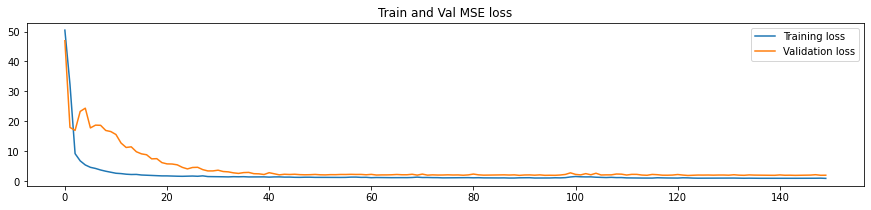

In [24]:
if __name__ == '__main__':

    # This is a neural network that predicts a structure of SH2 attached to a peptide.
    # Pay attention to create inputs and labels to the network using the code in the utils script.

    model = build_network()

   # TODO: update to "save_path" you chose in utils script
   # we use it to load here your input and labels data,
   # pdbs and sequences you created in utils script
    data_path = "/content/drive/MyDrive/protein_hackaton_data/data_to_network"


    # ~~~ load your input and labels: ~~~ # 
    X = np.load(f"{data_path}/train_input.npy") # X = numpy array of shape (1974,NB_MAX_LENGTH,FEATURE_NUM) of all the data input.
    Y = np.load(f'{data_path}/train_labels.npy') # Y = numpy array of shape (1974,NB_MAX_LENGTH,OUTPUT_SIZE) of all the data labels.
    
    # ~~~ split to test and train: ~~~ # 
    # we split to test and train in a manner that keeps the indices of each set
    test_indices = np.random.choice(X.shape[0], X.shape[0] // TEST_PERCENT , replace=False)
    X_test = X[test_indices]
    y_test = Y[test_indices]
    X_train = X[np.logical_not(np.isin(np.arange(X.shape[0]), test_indices))]
    y_train = Y[np.logical_not(np.isin(np.arange(X.shape[0]), test_indices))]

    X_train = tf.convert_to_tensor(X_train)
    X_test = tf.convert_to_tensor(X_test)
    y_train = tf.convert_to_tensor(y_train)
    y_test = tf.convert_to_tensor(y_test)

  #   # ~~~ training: ~~~ #
  #   ## if you already have a traind model, move to load model section

  #  compile model using Adam optimizer (with learning rate of your choice) and MSE loss.
    my_optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
    model.compile(optimizer=my_optimizer, loss="mse")

    # TODO: give the path to where you want to save your best ckpt:
    ckpt_best_path = "/content/drive/MyDrive/protein_hackaton_data/best_ckpt/"
    model_ckpt = tf.keras.callbacks.ModelCheckpoint(filepath=ckpt_best_path, monitor="val_loss", mode=min, save_best_only=True)

    # fit model (use EPOCH for epoch parameter and BATCH for batch_size parameter)
    history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH, validation_data=(X_test, y_test), callbacks=[model_ckpt])
    
    # plot train loss:
    plot_val_train_loss(history)
    
    # ~~~ load model from checkpoint: ~~~ #

    # TODO: give the path to exist checkpoint
    ckpt_path = "/content/drive/MyDrive/protein_hackaton_data/best_ckpt"

    # load model
    model = tf.keras.models.load_model(ckpt_path)

    # fit model (use EPOCH for epoch parameter and BATCH for batch_size parameter)
    history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH, validation_data=(X_test, y_test))
    
    # plot train loss:
    plot_val_train_loss(history)

    
    # ~~~ predictions & evaluating: ~~~ #

    # load your sequences and pdb:
    # In order to make a prediction and pdb files ot them, you need the sequences
    # and pdb names of the sh2 and peptide.
    
    all_seqs_sh2 = []
    with open(f"{data_path}/all_seqs_sh2.txt", "r") as f:
      for line in f:
        all_seqs_sh2.append(line.strip())

    all_seqs_pep = []
    with open(f"{data_path}/all_seqs_pep.txt", "r") as f:
      for line in f:
        all_seqs_pep.append(line.strip())

    all_pdbs = []
    with open(f"{data_path}/all_pdbs.txt", "r") as f:
      for line in f:
        all_pdbs.append(line.strip())


    # TODO: you can choose here to where you want to save your pdb predictions: 
    save_path = "/content/drive/MyDrive/protein_hackaton_data/pred_pdbs/"

    # created pdbs of prediction to test set:    
    test_path = f"{save_path}/test_set"
    isExist = os.path.exists(test_path)
    if not isExist:
      os.mkdir(test_path)

    for i in range(X_test.shape[0]):
      X_pred = np.expand_dims(X_test[i], axis=0)
      X_pred_sh2 = X_pred[:,:utils_new.SH2_MAX_LEN,:]
      X_pred_pep = X_pred[:,utils_new.SH2_MAX_LEN:,:]

      Y_pred = model.predict(X_pred, batch_size = (1))
      Y_pred_sh2 = Y_pred[:,:utils_new.SH2_MAX_LEN,:]
      Y_pred_pep = Y_pred[:,utils_new.SH2_MAX_LEN:,:]

      seq_sh2 = all_seqs_sh2[test_indices[i]]
      seq_pep = all_seqs_pep[test_indices[i]]
      
      pdb_name = all_pdbs[test_indices[i]]
      path = f"{test_path}/{pdb_name}"
      isExist = os.path.exists(path)
      if not isExist:
        os.mkdir(path)

      matrix_to_pdb(seq_sh2, Y_pred_sh2[0], f"{test_path}/{pdb_name}/SH2_pred")
      matrix_to_pdb(seq_pep, Y_pred_pep[0], f"{test_path}/{pdb_name}/peptide_pred")

    # created pdbs of prediction to train set: 
    train_path = f"{save_path}/train_set"
    isExist = os.path.exists(train_path)
    if not isExist:
      os.mkdir(train_path)

    for i in range(X_test.shape[0]):
      X_pred = np.expand_dims(X_train[i], axis=0)
      X_pred_sh2 = X_pred[:,:utils_new.SH2_MAX_LEN,:]
      X_pred_pep = X_pred[:,utils_new.SH2_MAX_LEN:,:]

      Y_pred = model.predict(X_pred, batch_size = (1))
      Y_pred_sh2 = Y_pred[:,:utils_new.SH2_MAX_LEN,:]
      Y_pred_pep = Y_pred[:,utils_new.SH2_MAX_LEN:,:]

      train_indices = [i for i in range(X.shape[0]) if i not in test_indices]

      seq_sh2 = all_seqs_sh2[train_indices[i]]
      seq_pep = all_seqs_pep[train_indices[i]]

      pdb_name = all_pdbs[train_indices[i]]
      path = f"{train_path}/{pdb_name}"
      isExist = os.path.exists(path)
      if not isExist:
        os.mkdir(path)

      matrix_to_pdb(seq_sh2, Y_pred_sh2[0], f"{train_path}/{pdb_name}/SH2_pred")
      matrix_to_pdb(seq_pep, Y_pred_pep[0], f"{train_path}/{pdb_name}/peptide_pred")

In [23]:
BACKBONE_ATOMS = ["N", "CA", "C", "O", "CB"]

def matrix_to_pdb(seq, coord_matrix, pdb_name):
    """
    Receives a sequence (String) and the output matrix of the neural network (coord_matrix, numpy array)
    and creates from them a PDB file named pdb_name.pdb.
    :param seq: protein sequence (String), with no padding
    :param coord_matrix: output np array of the nanobody neural network, shape = (NB_MAX_LENGTH, OUTPUT_SIZE)
    :param pdb_name: name of the output PDB file (String)
    """
    ATOM_LINE = "ATOM{}{}  {}{}{} {}{}{}{}{:.3f}{}{:.3f}{}{:.3f}  1.00{}{:.2f}           {}\n"
    END_LINE = "END\n"
    k = 1
    with open(f"{pdb_name}.pdb", "w") as pdb_file:
        for i, aa in enumerate(seq):
            # print("aa: ", aa)
            third_space = (4 - len(str(i))) * " "
            for j, atom in enumerate(BACKBONE_ATOMS):
                if not (aa == "G" and atom == "CB"):  # GLY lacks CB atom
                    x, y, z = coord_matrix[i][3*j], coord_matrix[i][3*j+1], coord_matrix[i][3*j+2]
                    b_factor = 0.00
                    first_space = (7 - len(str(k))) * " "
                    second_space = (4 - len(atom)) * " "
                    forth_space = (12 - len("{:.3f}".format(x))) * " "
                    fifth_space = (8 - len("{:.3f}".format(y))) * " "
                    sixth_space = (8 - len("{:.3f}".format(z))) * " "
                    seventh_space = (6 - len("{:.2f}".format(b_factor))) * " "
                    if aa=="X":
                      three="UNK"
                    else:
                      three = Polypeptide.one_to_three(aa)
                    pdb_file.write(ATOM_LINE.format(first_space, k, atom, second_space, three , "H", third_space, 
                                                    i, forth_space, x, fifth_space, y, sixth_space, z, seventh_space,
                                                    b_factor, atom[0]))
                    k += 1

        pdb_file.write(END_LINE)